# MAC0318 - Teoria de controle - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e a biblioteca NumPy instalada. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter e a manipulação de matrizes usando a bilbioteca NumPy. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Sistemas dinâmicos

Um sistema é descrito matematicamente como uma função que mapeia sinais de entradas em sinais de saídas. Um sistema dinâmico é tal que a transformação de entrada em saída varia com o tempo. Matematicamente, descrevemos tal sistema por uma função $`y_t = f(u_t, t)`$, onde $`y_t`$ é a saída do sistema no tempo $`t`$ e $`u_t`$ é a entrada no mesmo instante. Sistemas dinâmicos de tempo contínuo são normalmente descritos por um sistema de equações diferenciais ordinárias (EDO):
$$
\dot{s}_t = g(s_t,u_t,t), \qquad y_t = h(s_t,u_t,t).
$$
A variável $s_t$ é o vetor de estado do sistema e $\dot{s}_t$ sua primeira derivada em relação tempo. Podemos obter a evolução do sistema, resolvendo as EDO:
$$
s_t(u_t, t) = \int_{t_0}^t g(s_\tau, u_\tau, \tau) d\tau .
$$
E dessa forma obtemos $y_t = f(u_t,t)$.

Já sistemas de tempo discreto (ou seja, quando $t = 0,1,\ldots$) são normalmente descritos por equações de diferenças:
$$
s_{t+1} = g(s_t,u_t,t) .
$$

Em ambos os casos, dizemos que o sistema é invariante no tempo se para todo $t$ e $k$, temos:
$$`
g(s,u,t+k) = g(t,s,u) \text{ e } h(s,u,t+k).
`$$

### Sistema massa-mola

<figure style='float:right'>
    <div style="text-align:center;">
        <img src="img/spring_mass.png" width="350" alt="spring-mass system">
    </div>
</figure>

Um exemplo simples mas interessante de sistema dinâmico é a descrição da posição e velocidade de um objeto rígido com massa preso a uma mola, com uma de suas extremidades fixa. Tal sistema é chamado mass-mola ou também integrador duplo, devido a uma dupla integral de seu estado, como veremos. Considere portanto o sistema ilustrado na figura ao lado, com as seguintes definições:

- $m$: massa do corpo rígido [kg]
- $q$: distância do objeto à parede [m]
- $v$: velocidade do objeto [m/s]
- $a$: aceleração do objeto [m/s^2]
- $F_u$: força estimuladora [N]
- $C$: coeficiente de amortecimento linear
- $K$: constante elástica (stiffness) da mola

Vamos definir o estado como
$$`
s_t = \begin{pmatrix} x_t \\ v_t \end{pmatrix}.
`$$

Vamos supor que a força $F_u$ segue um sinal dado por $u_t$. De acordo com a segunda Lei de Newton, temos que:
$$
m\dot{v}_t = u_t - C v_t - K q_t
$$

Rearrajando termos e colocando em notação matricial, podemos representar o sistema dinâmico de tempo contínuo como a seguinte equação de transição no espaço de estados:
$$
 \begin{bmatrix}
 \dot{q} \\ \dot{v}
 \end{bmatrix}
 =
 \begin{bmatrix}
 0 & 1 \\ -K/m & -C/m
 \end{bmatrix}
  \begin{bmatrix}
  q \\ v
 \end{bmatrix}
 +
 \begin{bmatrix}
 0 \\ 1/m
 \end{bmatrix}
 u
$$
Note que o sistema acima descreve uma transformação linear invariante no tempo da forma $\dot{q} = f(q,u) = Aq + Bu$. Tais sistemas gozam de diversas propriedades importantes.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# 
# State-space dynamics
# 
# Constants
K = 0.6  # spring constant (K=6 - stable, K=60, unstable
C = 2.0  # damping
m = 2.0    # mass [kg]
# State s = [x, v]
# Homogenous Transition Matrix
A = np.array([[0, 1], [-K/m, -C/m]])
# Inhomogenous component
b = np.array([[0],[1/m]])

# Euler approximation to differential state-space equation
def forward(s, dt):
    #u = control(s, dt)
    u = 0.0
    ds = A @ s + b * u
    s += ds*dt

In [3]:
# Vamos usar a função forward para simular a evolução do estado do robô a partir
# de um estado inicial para 2 passos de tempo com sinais de controle variando

x = np.zeros(3) # estado inicial x(0) = [0,0,0]
print('x(0) =', x)
forward(x, 0.2, 0, 0.1) # move adiante com velocidade de 0.2m/s por 0.1s
print('x(1) =', x)
forward(x, 0., 10, 0.1) # gira a 10 rad/s no eixo por 0.1s
print('x(2) =', x)

x(0) = [0. 0. 0.]
x(1) = [0.02 0.   0.  ]
x(2) = [0.02 0.   1.  ]


## Estabilidade de sistemas dinâmicos

Um sistema é descrito matematicamente como uma função que mapeia sinais de entradas em sinais de saídas. Um sistema dinâmico é tal que a transformação de entrada em saída varia com o tempo. Matematicamente, descrevemos tal sistema por uma função $`y_t = f(u_t, t)`$, onde $`y_t`$ é a saída do sistema no tempo $`t`$ e $`u_t`$ é a entrada no mesmo instante. Para nosso robô de tempo discreto, o sistema dinâmico mapeia um sinal de controle $`u_t = \begin{pmatrix} v_t & w_t \end{pmatrix}`$ em um novo estado $`x_{t}`$, que pode também ser visto como a saída:

$$`
y_t = x_t = f(v_t,w_t,t) .
`$$

Há muitas formas de definir establidade de um sistema dinâmico. A mais comum é a que conecta estabilidade ao conceito de saída finita, chamado em inglês de [*Bounded-Input, Bounded-Output* (BIBO)](https://en.wikipedia.org/wiki/BIBO_stability). De acordo com esse conceito, um sistema descrito em tempo discreto por estados $`x_0,x_1,\ldots`$ é estável se sua saída é limitada sempre que sua entrada também o for. Um sinal $f_t$ é limitado se existe uma constante $`B > 0`$ que limita superiormente a magnitude do sinal isto é, se $`|x_t| < B`$ para qualquer $`t > 0`$. Por exemplo, o sistema de tempo contínuo descrito pela equação 
$$`
y_t = e^{-t} u_t
`$$ 
é BIBO-estável, pois para $`u_t < C`$ temos que $`y_t < C`$ para qualquer $`C > 0`$. Já o sistema descrito por
$$`
y_t = e^{t} u_t
`$$ 
não é BIBO-estável, pois para $`u_t = 1`$ não existe nenhuma constante $`C`$ satisfazendo $`y_t < C`$ para todo $`t > 0`$. Para sistemas que dependem de condições inicias, em geral definimos BIBO-estabilidade assumindo condições iniciais nulas (por exemplo, que a posição e velocidades do robô são zero no instante inicial).

## Exercício 1

Podemos dizer que o sistema de cinemática direta que descreve a pose do robô $`q(t)`$ em função das velocidades $`v(t)`$ e $`w(t)`$ acima é BIBO-estável? Justifique sua resposta, apontando porque o estado descrito pelo sistema será limitado com entradas limitadas ou apontando um contra-exemplo. Você pode usar as simulações das função `forward` como aproximações da dinâmica verdadeira do sistema para justificar sua resposta.

### RESPOSTA

<span style="color:red">Escreva sua resposta aqui</span>

In [ ]:
#
# Control law
#
t_elapsed = 0
# Reference:
def control(s, dt):
    global t_elapsed
    t_elapsed += dt
    return (np.sin(3*t_elapsed) + np.cos(4*t_elapsed))/t_elapsed


In [ ]:
# Initial state
s = np.array([[0.2], [0.0]])

In [ ]:
dt = 0.1
x_hist = []
v_hist = []
for _ in range(500):
    forward(s, dt)
    x_hist.append(s[0,0])
    v_hist.append(s[1,0])   

NameError: name 'forward' is not defined

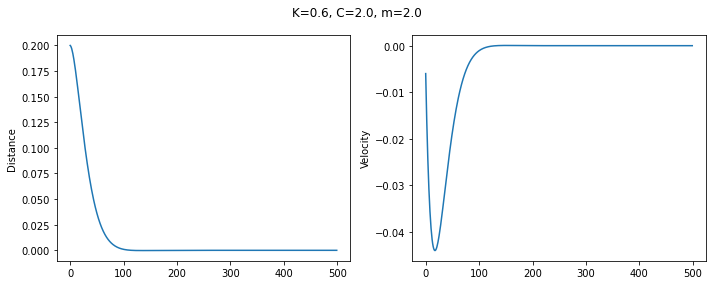

In [ ]:
_, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(x_hist);
ax[0].set_ylabel('Distance');
ax[1].plot(v_hist);
ax[1].set_ylabel('Velocity');
plt.suptitle(f"K={K}, C={C}, m={m}")
plt.tight_layout()
plt.savefig(f"spring-mass-{K}-{C}.pdf")

In [ ]:
t_elapsed